In [39]:
import collections,spacy,unicodedata
import tensorflow
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pattern
import re
import seaborn as sns
import string
import keras
import time
from collections import Counter
from keras.datasets import imdb
from keras.layers import Dense,Embedding,Flatten,LSTM  
from keras.layers.convolutional import Conv1D, MaxPooling1D 
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing import sequence
from nltk import tokenize
from nltk.corpus import stopwords, wordnet
from nltk.corpus import opinion_lexicon
from nltk.stem import LancasterStemmer, PorterStemmer, WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import treebank
from pattern.en import lemma, lexeme
from pprint import pprint
from scipy import stats
from sklearn import svm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob, Word
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt')
#nltk.download('wordnet')

In [37]:
stopwords_list = stopwords.words('english')
hh = np.array(stopwords_list)
# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [40]:
tokenizer = treebank.TreebankWordTokenizer()
pos_list=set(opinion_lexicon.positive())
neg_list=set(opinion_lexicon.negative())

In [41]:
def sentiment(sentence):
    senti=0
    words = [word.lower() for word in tokenizer.tokenize(sentence)]
    for word in words:
        if word in pos_list:
            senti += 1
        elif word in neg_list:
            senti -= 1
    return senti

In [36]:
# create a doamin specific list of neutral words which should have no impact on the review score
ao = ['cd','lp','band','album','record','song','year','release','minute','hour','beat','per','sing','music','genre','producer','artist','lyrics','lyric','genres','producers','bar','note','tempo','rhythm','track','play','playlist','bpm','chart','chorus','verse','deejay','duo','solo','session','scale','singer','vocalist', 'sound']
ao2 = [r'\b'+i+r'\b' for i in ao]
ao3 = [j + '|' if i < len(ao2)-1 else j for i,j in enumerate(ao2)]
res = "".join(ao3)


In [42]:
df = pd.read_csv("Content2.csv",index_col='reviewid')
df = df[df['score'] > 0.8]


In [18]:
df0 = df.copy()
df0['content'] = df['content'].apply(lambda x: x.replace(u'\xa0', u' '))

In [21]:
# Tokenise into sentences
aa0 = df0['content'].apply(lambda x: tokenize.sent_tokenize(x))

In [4]:
df['nc'] = df['content'].apply(lambda x: x.replace(u'\xa0', u' '))
df['nc'] = df['nc'].apply(lambda x: re.sub(r'[,<>.;:!()\[\]{}?«»“”‘"]',' ',x))
df['nc'] = df['nc'].apply(lambda x: x.lower())
df['nnc'] = df['nc'].apply(lambda x: x.split())
df['wc'] = df['nnc'].apply(lambda x: len(x))
df['nc2'] = df['nc'].apply(lambda x: re.sub(r'\btime\b|\btell\b|\bcome\b|\bsound\b|\bmusic\b|\bpitchfork\b|\bplay\b|\bplays\b|\bband\b|\balbum\b|\brecord\b|\bsong\b|\byear\b|\brelease\b|\bmake\b|\btake\b|\bsee\b|\bbecome\b|\bminute\b|\bhour\b|\bfeel\b|\bbeat\b|\bsing\b|\btrack\b|\bknow\b|\bep\b|\bartist\b','',x))


In [5]:
cut_labels_4 = ['Poor', 'Average', 'Good', 'Excellent']
cut_bins = [0, 5.5, 7, 8, 10]
df['cut_ex1'] = pd.cut(df['score'], bins=cut_bins, labels=cut_labels_4)

In [6]:
df1 = df.copy()

In [7]:
df['cut_ex1'].value_counts()

Good         7328
Average      5943
Excellent    2974
Poor         2094
Name: cut_ex1, dtype: int64

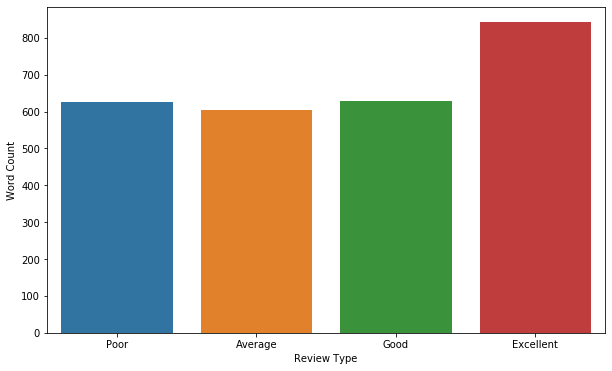

In [8]:
fy = df.groupby('cut_ex1').mean().reset_index()
plt.figure(figsize=(10,6))
cdq = sns.barplot(x='cut_ex1',y = 'wc',data=fy)
cdq.set(xlabel='Review Type', ylabel='Word Count')
plt.show()

In [96]:
# Preprocessing - cleaning of text
df1['content'] = df1['content'].apply(lambda x: x.replace(u'\xa0', u' '))
df1['content'] = df1['content'].apply(lambda x: re.sub(r'“[^”]+”{1}?',' ',x))
df1['content'] = df1['content'].apply(lambda x: re.sub(r'"[^"]+"{1}?',' ',x))
df1['content'] = df1['content'].apply(lambda x: re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''',' ',x))
df1['content'] = df1['content'].apply(lambda x: re.sub(r'\S*@\S*\s?',' ',x))
df1['content'] = df1['content'].apply(lambda x: re.sub(r'\S*#\S*\s?',' ',x))
df1['content'] = df1['content'].apply(lambda x: re.sub(r'[A-Z].*?\s{1}?',' ',x))
df1['content'] = df1['content'].apply(lambda x: re.sub(r'[0-9]',' ',x))
df1['content'] = df1['content'].apply(lambda x: x.lower())
df1['content'] = df1['content'].apply(lambda x: re.sub(r'’',"'",x))
df1['content'] = df1['content'].apply(lambda x: re.sub(r"[^a-zA-Z']",' ',x))
df1['content'] = df1['content'].apply(lambda x: ' '.join(np.array(list(x.split()))[~np.in1d(np.array(list(x.split())),hh)]))
df1['content'] = df1['content'].apply(lambda x: re.sub(r"'",' ',x))
df1['content'] = df1['content'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))
df1['content'] = df1['content'].apply(lambda x: re.sub(r'\b\w{1,2}\b', ' ',x))
df1['content'] = df1['content'].apply(lambda x: re.sub(r'-[A-Za-z]+-?',' ',x))
df1['content'] = df1['content'].apply(lambda x: re.sub(r' +',' ',x))


In [87]:
def clean_text(x):
    x = x.replace(u'\xa0', u' ')
    x = re.sub(r'“[^”]+”{1}?',' ',x)
    x = re.sub(r'"[^"]+"{1}?',' ',x)
    x = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''',' ',x)
    x = re.sub(r'\S*@\S*\s?',' ',x)
    x = re.sub(r'\S*#\S*\s?',' ',x)
    x = re.sub(r'[A-Z].*?\s{1}?',' ',x)
    x = re.sub(r'[0-9]',' ',x)
    x = x.lower()
    x = re.sub(r'’',"'",x)
    x = re.sub(r"[^a-zA-Z']",' ',x)
    x = ' '.join(np.array(list(x.split()))[~np.in1d(np.array(list(x.split())),hh)])
    x = re.sub(r"'",' ',x)
    x = " ".join([token.lemma_ for token in nlp(x)])
    x = re.sub(r'\b\w{1,2}\b', ' ',x)
    x = re.sub(r'-[A-Za-z]+-?',' ',x)
    x = re.sub(r' +',' ',x)
    return x

In [98]:
df1 = df1[df1['content'].notnull()] # remove all the reviews that turned null after cleaning

In [100]:
df1[['content','score','wc','cut_ex1']].to_csv('RC.csv',index=True,encoding="utf-8")

In [3]:
df1 = pd.read_csv("RC.csv",index_col='reviewid')

In [4]:
from collections import Counter

def getMostCommonWords(reviews, n_most_common, stopwords=None):
    flattened_reviews = [word for review in reviews for word in review.lower().split()]

    return Counter(flattened_reviews).most_common(n_most_common)

In [5]:
getMostCommonWords(df1[df1['cut_ex1'] == 'Poor']['content'], 10)

[('like', 6696),
 ('album', 5605),
 ('song', 5364),
 ('sound', 4321),
 ('band', 3985),
 ('one', 3579),
 ('make', 3546),
 ('track', 3322),
 ('record', 3054),
 ('music', 2839)]

In [296]:
tt = getMostCommonWords(df1[df1['cut_ex1'] == 'Average']['content'], 10)
unzipped_object = zip(*tt)
unzipped_list = list(unzipped_object)
list(unzipped_list[0])

['like',
 'album',
 'song',
 'sound',
 'band',
 'track',
 'one',
 'make',
 'record',
 'music']

In [280]:
getMostCommonWords(df1[df1['cut_ex1'] == 'Good']['content'], 10)

[('like', 22489),
 ('album', 18875),
 ('song', 18163),
 ('sound', 16777),
 ('band', 12978),
 ('music', 12907),
 ('track', 12815),
 ('one', 12487),
 ('make', 11873),
 ('record', 11803)]

In [281]:
getMostCommonWords(df1[df1['cut_ex1'] == 'Excellent']['content'], 10)

[('like', 10770),
 ('album', 10271),
 ('song', 9415),
 ('sound', 8189),
 ('music', 7688),
 ('band', 7489),
 ('record', 7130),
 ('one', 7033),
 ('make', 6369),
 ('track', 6102)]

In [6]:
X = df1['content']
y = df1['score']
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size = 0.20)

In [7]:
count_vect = TfidfVectorizer(min_df = 10,max_df = 0.8,sublinear_tf = True, ngram_range = (1,1))
Xtr_counts = count_vect.fit_transform(Xtr)
feature_names = count_vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

Number of features: 17408


In [8]:
Xte_counts = count_vect.transform(Xte)

In [17]:
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# define feature selection
fs = SelectKBest(score_func=f_regression, k=500)
selected_features = fs.fit(Xtr_counts, ytr).get_support(indices=True)
# apply feature selection
X_selected = fs.fit_transform(Xtr_counts, ytr)

In [22]:
X_selected

<14671x500 sparse matrix of type '<class 'numpy.float64'>'
	with 596748 stored elements in Compressed Sparse Row format>

In [9]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xsc = scaler.fit_transform(pd.DataFrame(Xtr_counts.toarray()))


In [159]:
a1 = pd.DataFrame(Xtr_counts.toarray())

In [ ]:
a2 = pd.DataFrame(Xte_counts.toarray())

In [144]:
a3 = a1.mean(axis=0)
a4 = a1.std(axis=0)

In [146]:
a5 = a2

In [147]:
a6 = list(a2.columns)

In [148]:
for i in a6:
    a5[i] = (a2[i]-a3[i])/a4[i]

In [10]:
# best value for alpha lies between 0.01 and 0.08 probably for this data
lasso = Lasso(alpha=.03)
lasso.fit(Xsc, ytr)

Lasso(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [11]:
aqw = pd.DataFrame(abs(lasso.coef_), feature_names, columns=['Coefficient'])
aqw.sort_values(by='Coefficient',ascending = False)

Coefficient
bad            0.118927
problem        0.099594
reissue        0.081312
least          0.076606
decent         0.066875
...                 ...
folksinger     0.000000
folksong       0.000000
folkster       0.000000
folksy         0.000000
zydeco         0.000000

[17408 rows x 1 columns]

In [12]:
aqw[aqw['Coefficient'] > 0]

Coefficient
abstract        0.018504
abysmal         0.009671
accessible      0.028047
ache            0.009328
achievement     0.004376
...                  ...
whine           0.001671
world           0.014893
worse           0.006381
wound           0.001763
year            0.011918

[461 rows x 1 columns]

In [13]:
bb = Xtr_counts.toarray()

In [14]:
cc = bb[:,abs(lasso.coef_) > 0]

In [83]:
cc

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.05029205],
       [0.        , 0.        , 0.        , ..., 0.        , 0.04463218,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.04895668,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.03638161,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.03325843],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01958595,
        0.        ]])

In [15]:
bb2 = Xte_counts.toarray()
dd = bb2[:,abs(lasso.coef_) > 0]

In [163]:
dd

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.03498087],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.018921  ,
        0.        ]])

In [284]:
df2 = df1.copy()

reviewid
22703    eventually become punchline music press shorth...
22661    begin crash transpire one night long form germ...
22725    impossible consider give release footwork arti...
22745     boast open poverty respectability politic civ...
22719    perform something distinctly special spiritual...
                               ...                        
8835     concept late work invoke many record review do...
1242     back elementary school multimedia education me...
1023     ripple dive underground rock pond still splash...
6455     psyche okay drag guess tell move less three we...
1535     marketing guy yer average modern megaconglomer...
Name: content, Length: 2974, dtype: object

In [290]:
df2['content'] = df2['content'].apply(lambda x: re.sub(r'like|album|song|sound|band|track|one|make|record|music|get|time|work|feel|year|first|come|seem|vocal|take|way|two|release|could|also|play|though|back|little|would|thing|minute|something|title|voice|find|say|drum|give|end|beat|long|line|that|there|debut|know|point|hear|lyric|melody|around|set|part|single|turn|show|name|synth|self|use|live|without|group|hard|another|half|second|become|artist|see|three|cover','',x))


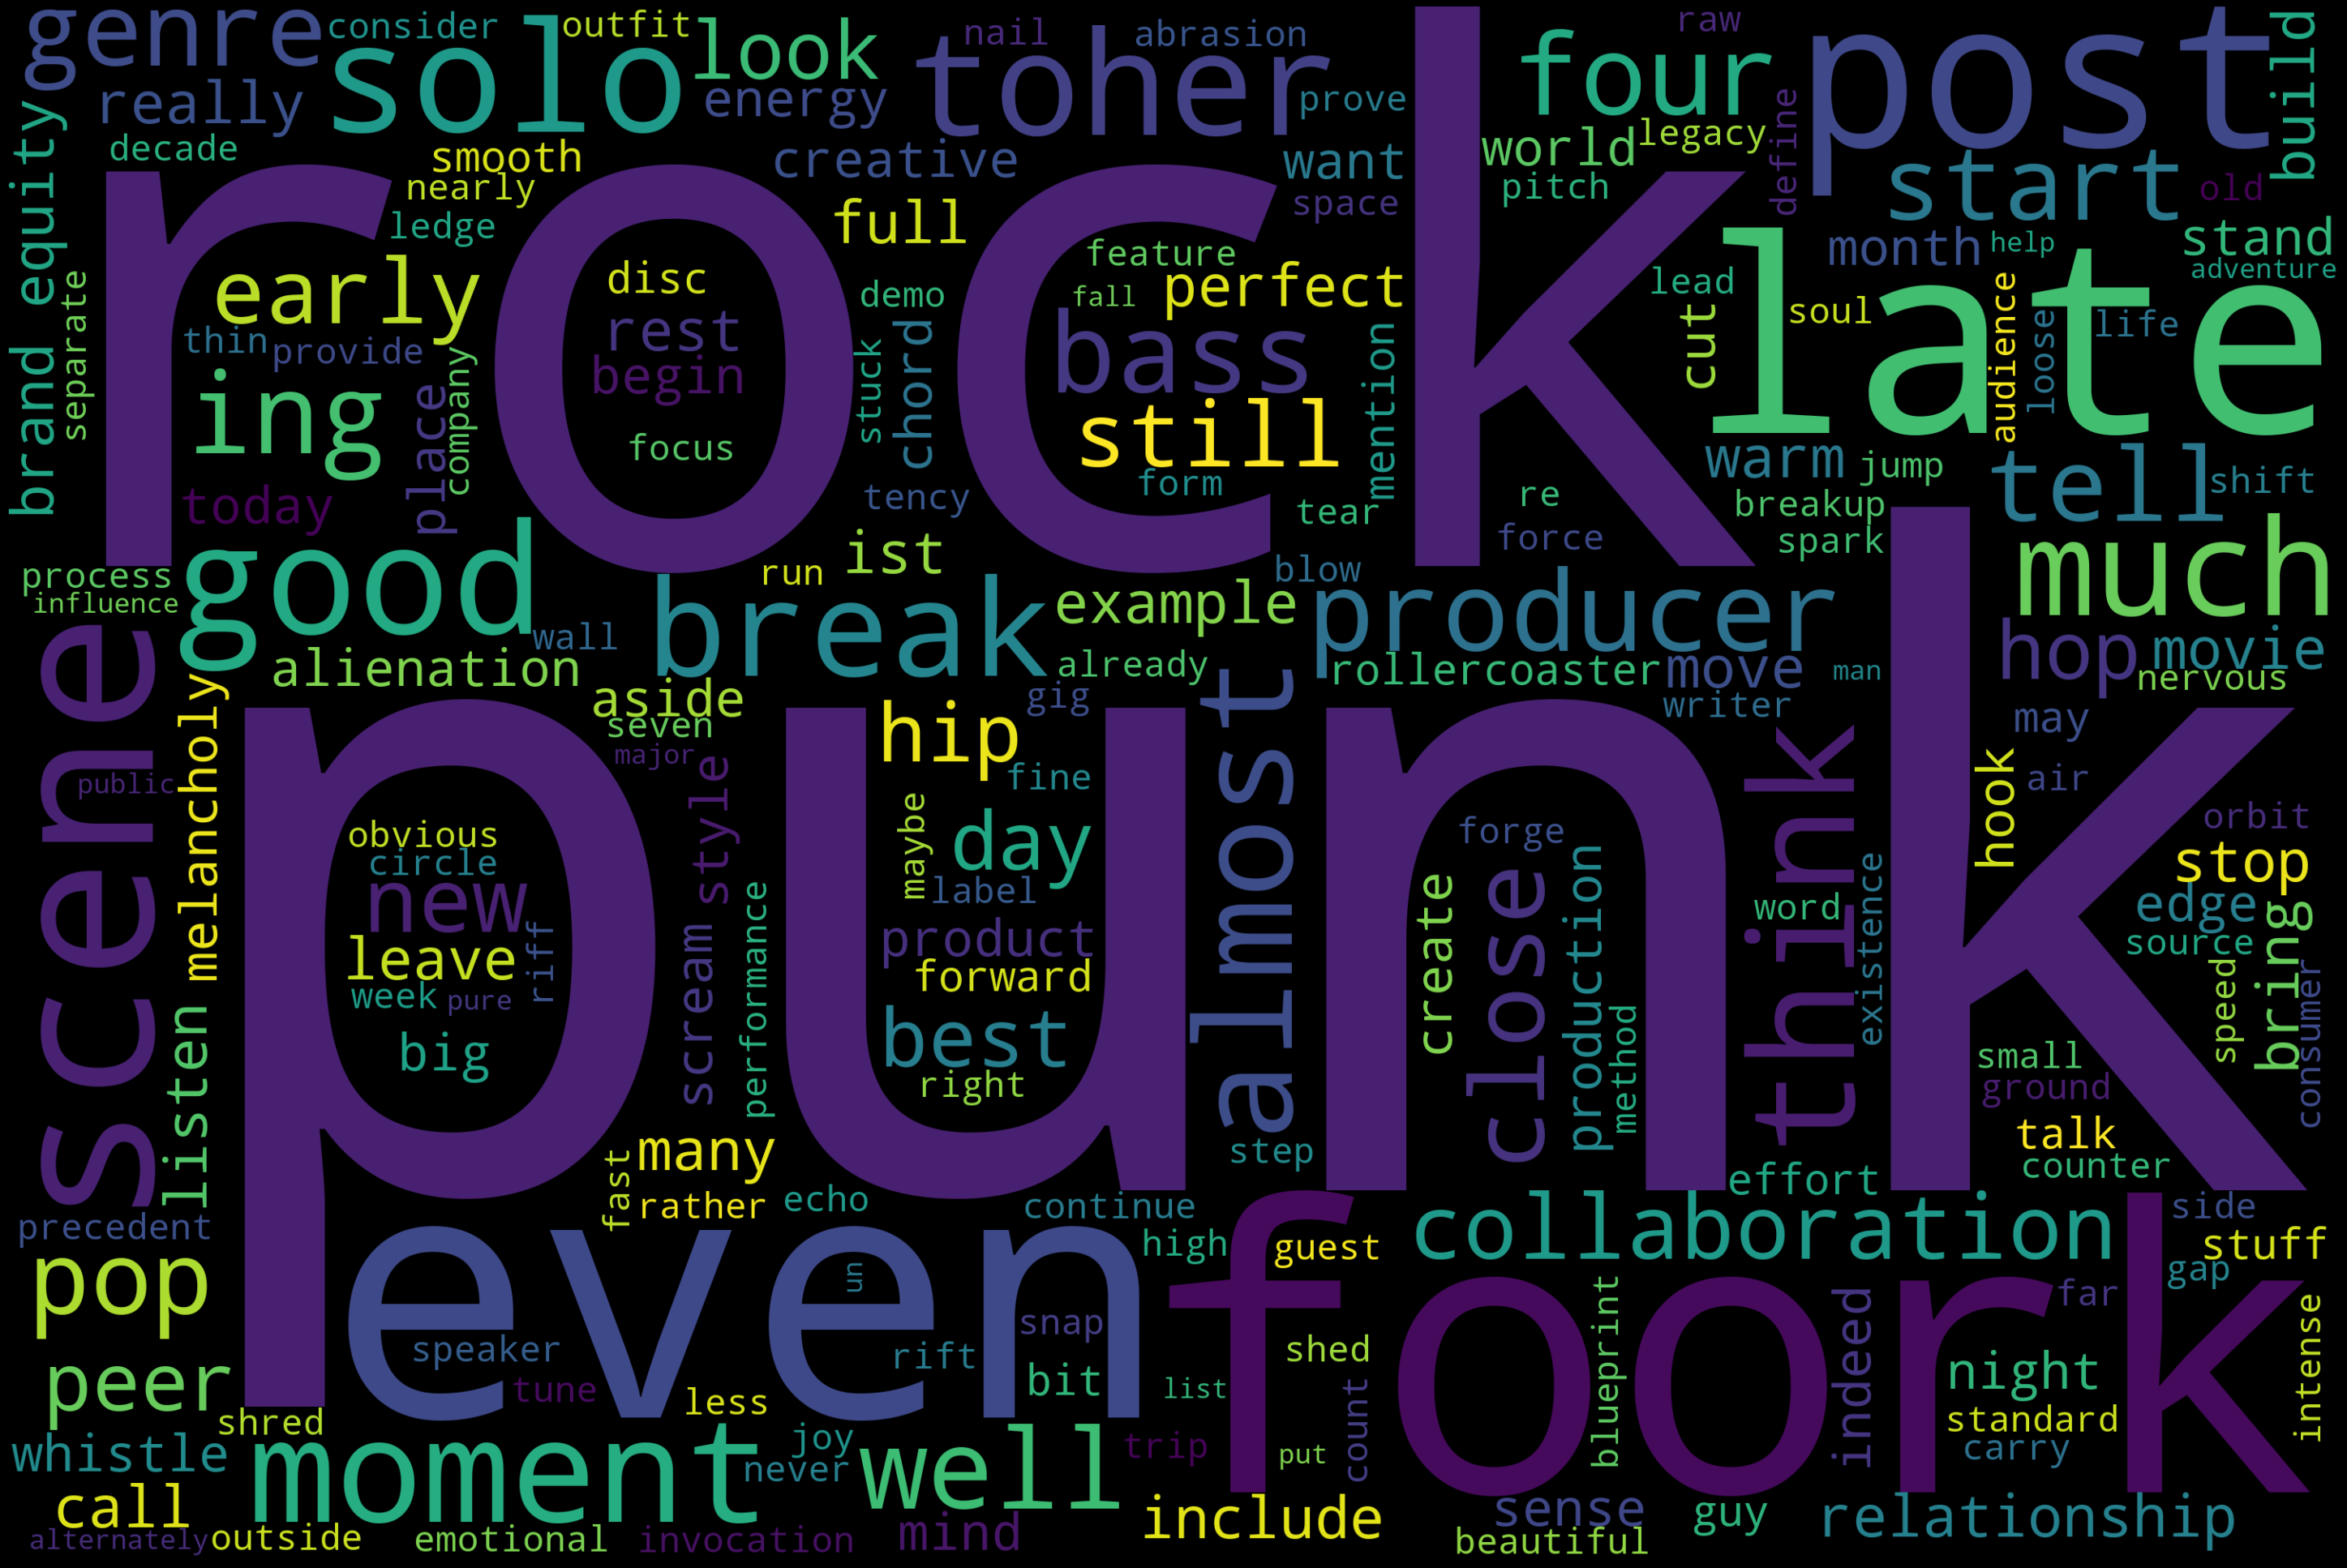

In [291]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = df2[df2['cut_ex1'] == 'Excellent']['content'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    #max_words=200,
    #max_font_size=40, 
    random_state=42,
    #background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

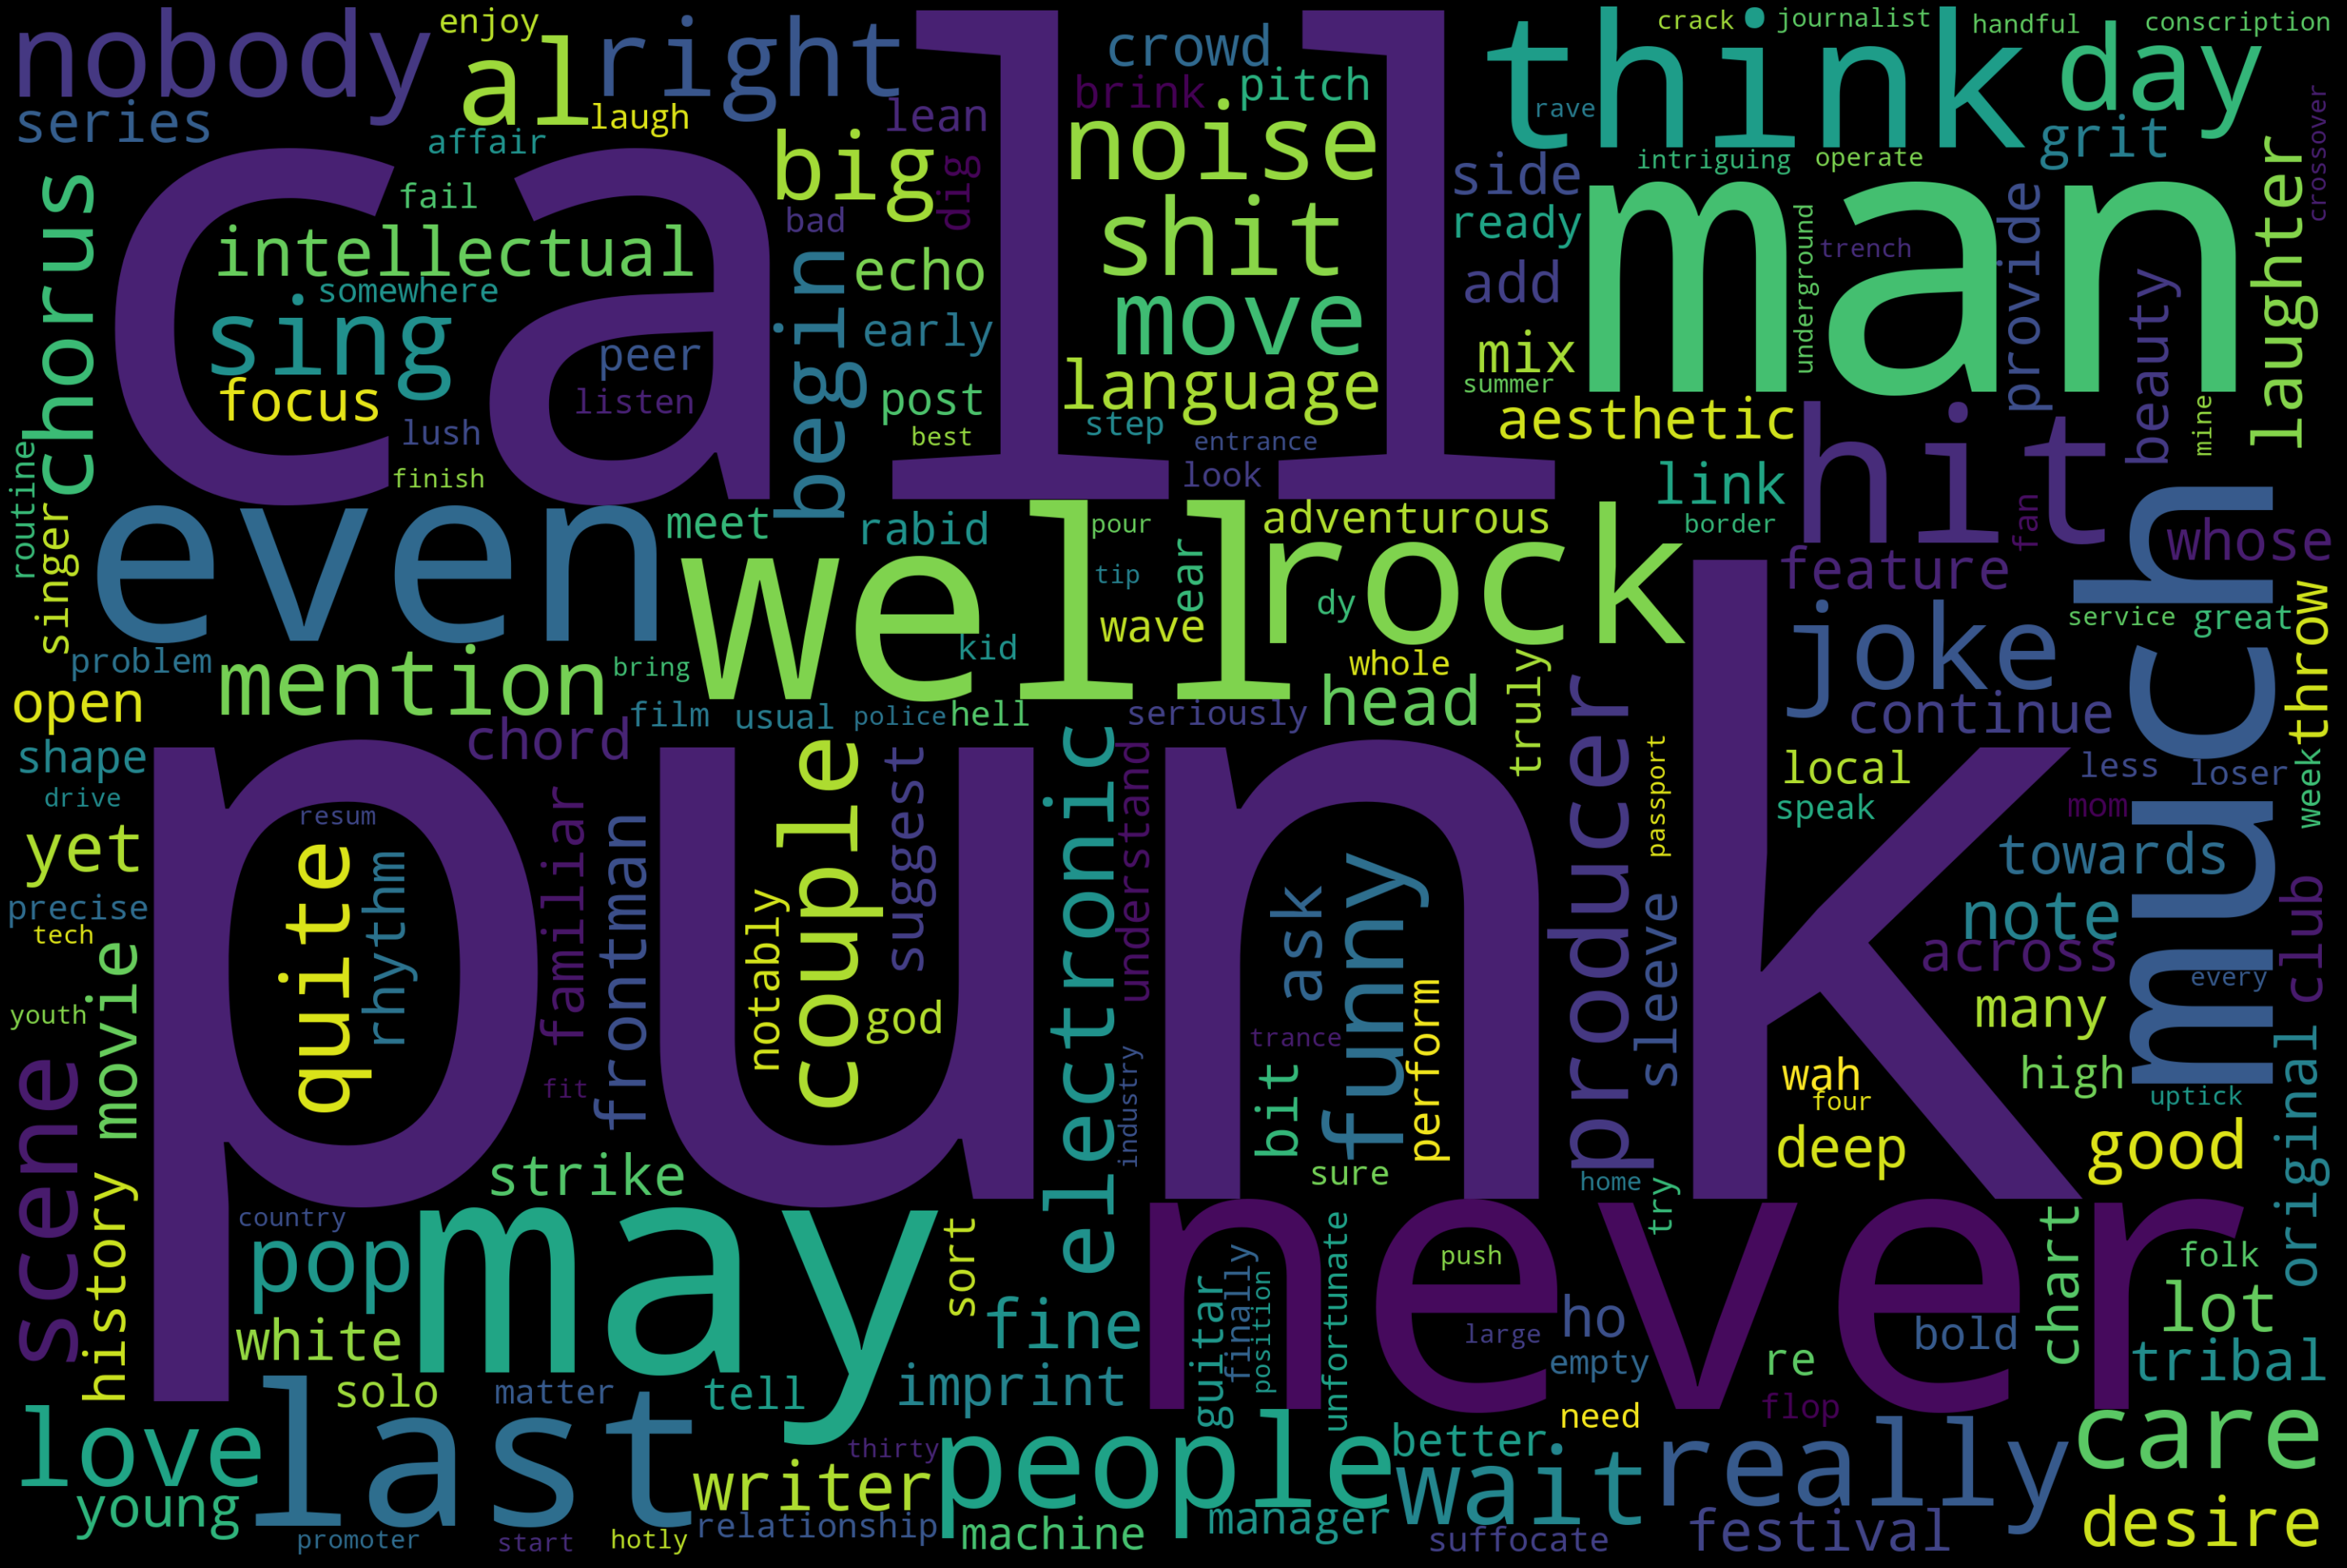

In [293]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = df2[df2['cut_ex1'] == 'Average']['content'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    #max_words=200,
    #max_font_size=40, 
    random_state=42,
    #background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

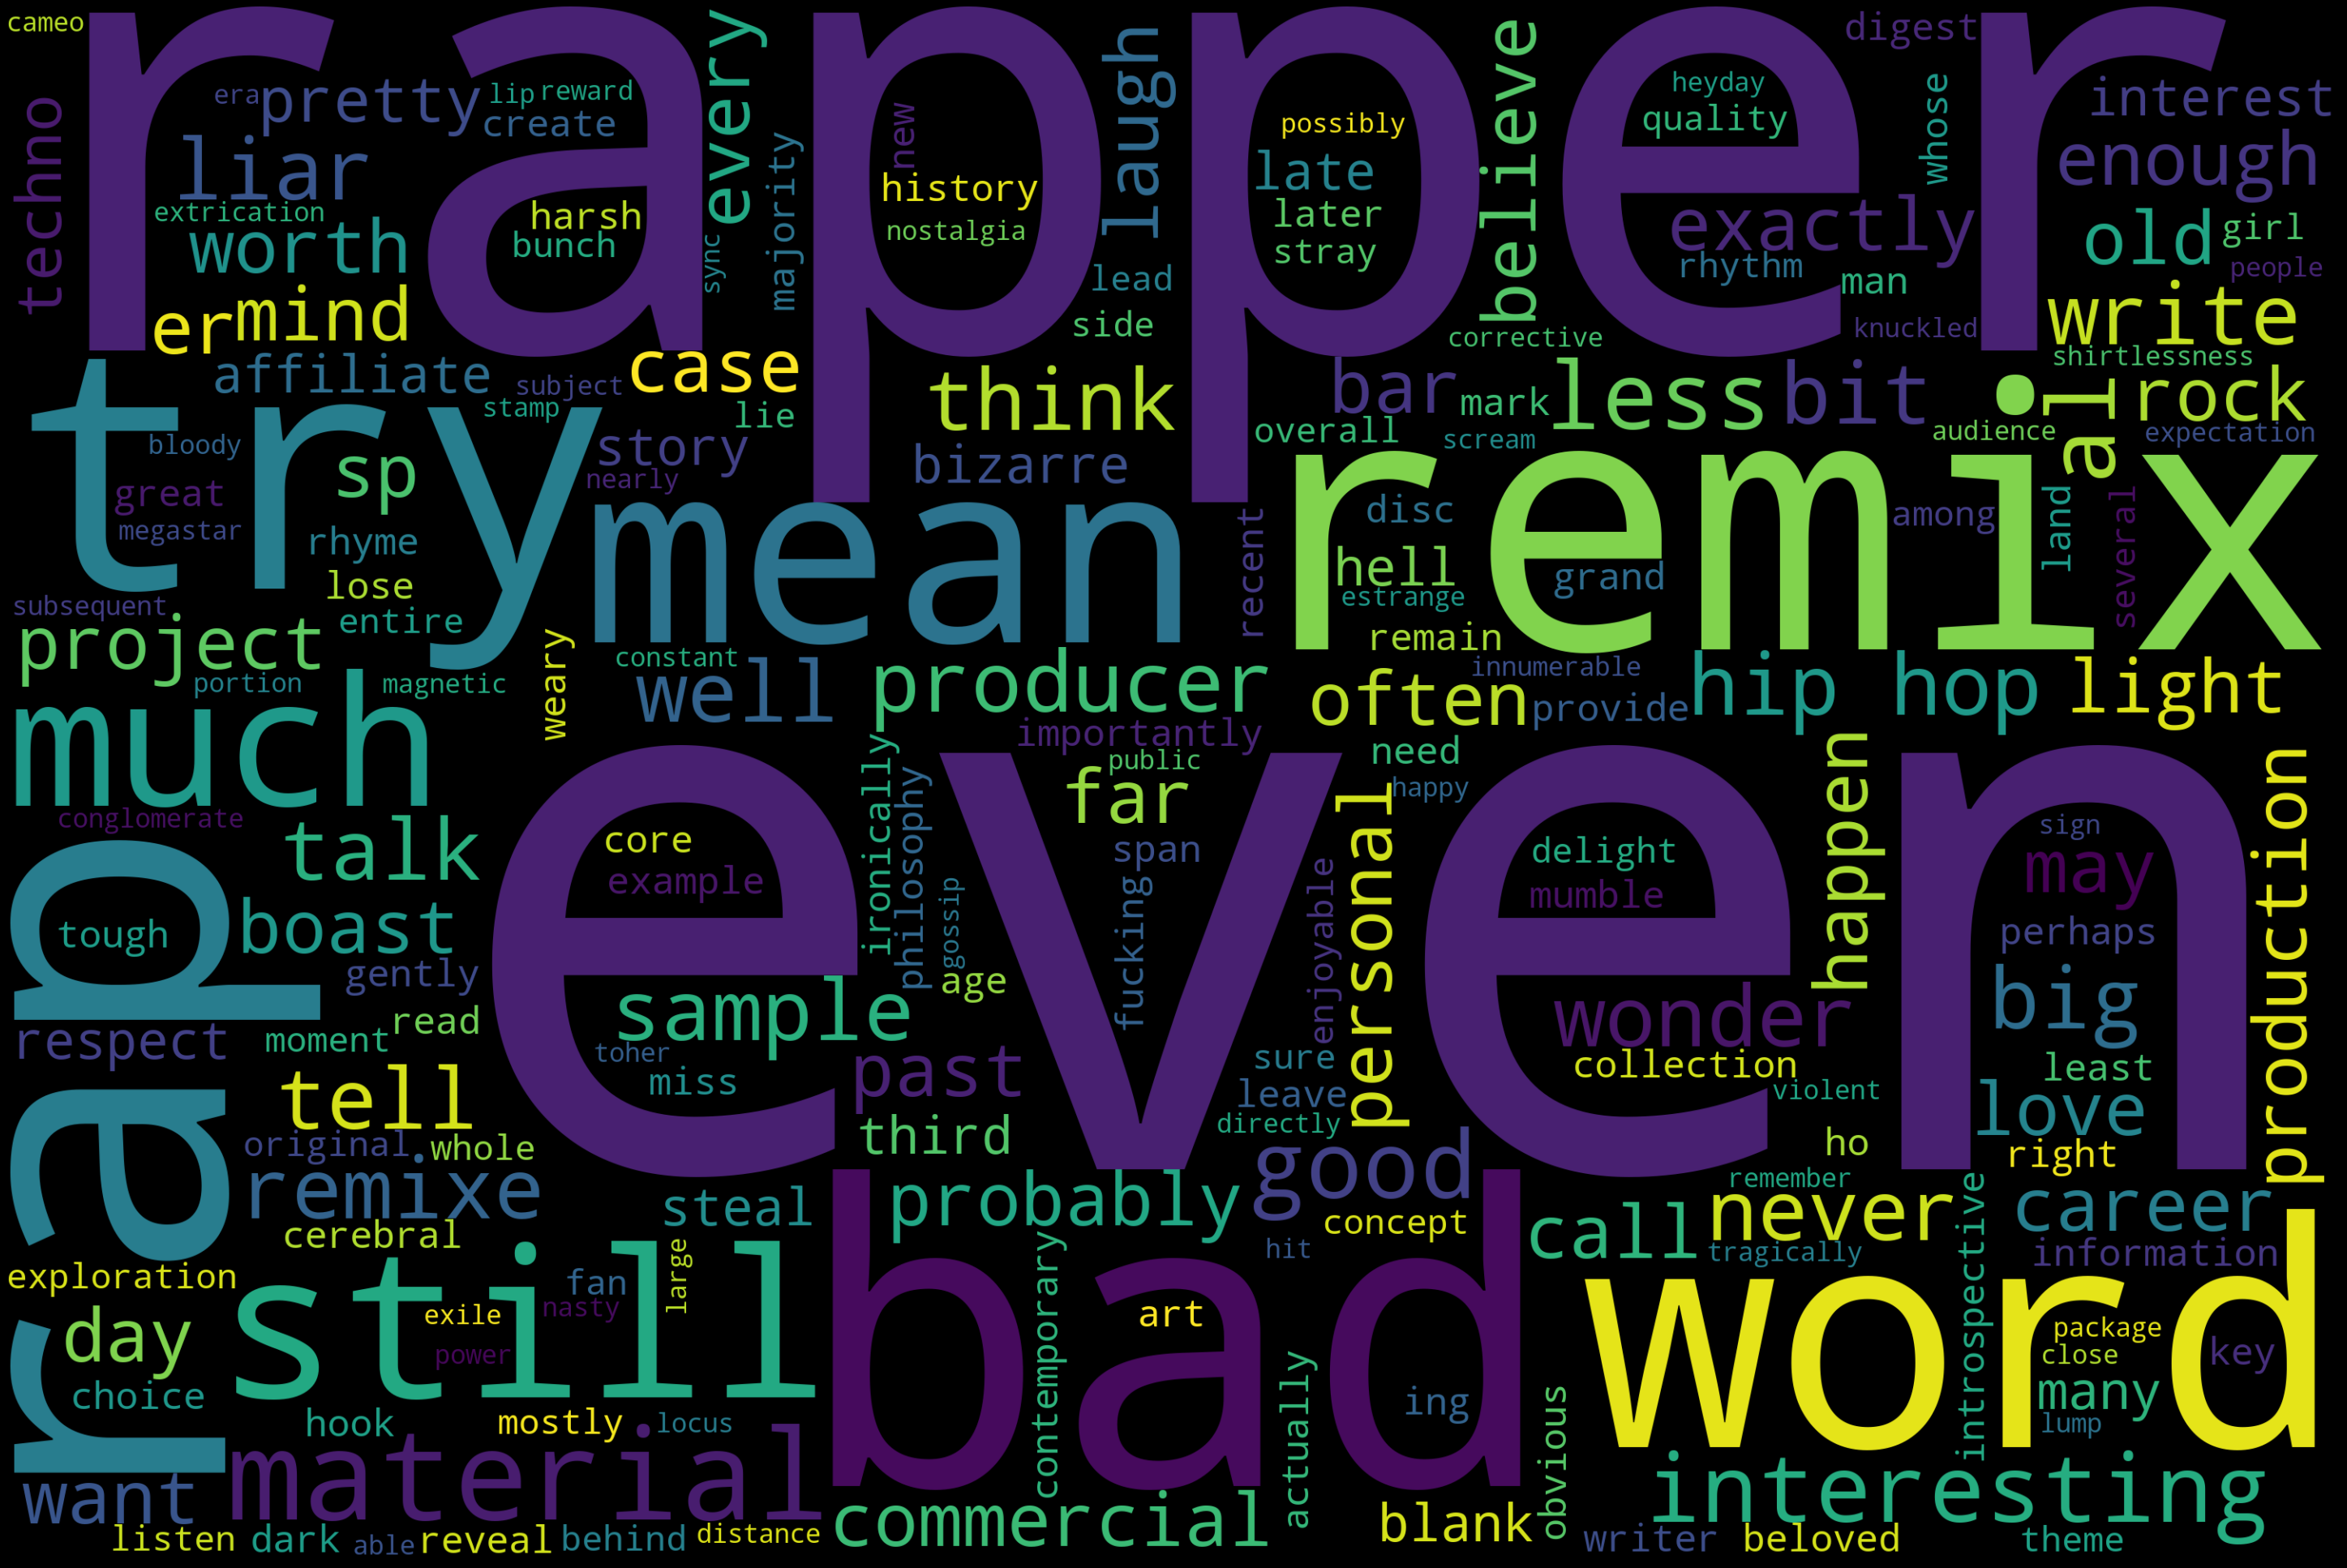

In [292]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = df2[df2['cut_ex1'] == 'Poor']['content'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    #max_words=200,
    #max_font_size=40, 
    random_state=42,
    #background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [142]:
ap = count_vect.get_feature_names()
ap.index('good')

11369

In [167]:
y = df1['score']

In [168]:
# Feature selection
selected_features = SelectKBest(f_regression, k=500).fit(X_train_counts, y).get_support(indices=True)
selected_features

array([   80,   127,   200,   246,   580,   582,   587,   630,   697,
         715,   720,   721,   731,   732,   741,   772,   779,   822,
         899,   968,  1050,  1065,  1159,  1278,  1313,  1406,  1411,
        1529,  1634,  1643,  1646,  1689,  1691,  1693,  1724,  1778,
        1822,  1870,  1871,  1875,  1999,  2004,  2115,  2116,  2118,
        2125,  2177,  2321,  2464,  2482,  2486,  2501,  2506,  2730,
        2805,  2866,  2870,  2943,  3041,  3119,  3120,  3126,  3220,
        3267,  3369,  3493,  3507,  3534,  3643,  3675,  3868,  3869,
        3899,  3902,  3921,  3980,  3990,  3998,  4238,  4344,  4392,
        4398,  4399,  4443,  4462,  4532,  4586,  4594,  4753,  4757,
        4822,  4918,  4960,  4967,  4990,  5008,  5011,  5144,  5221,
        5295,  5339,  5434,  5547,  5685,  5761,  5852,  6003,  6186,
        6218,  6308,  6386,  6411,  6429,  6509,  6513,  6554,  6715,
        6812,  6882,  6927,  7036,  7047,  7072,  7147,  7193,  7218,
        7272,  7386,

In [169]:
selector = SelectKBest(f_regression, k='all').fit(X_train_counts, y)
scores = selector.scores_
sc1 = pd.DataFrame(scores,columns = ['Score'])
sc1.sort_values('Score',ascending=False)

Score
1778   6.950945e+02
17383  5.067053e+02
20564  4.177050e+02
21909  3.962563e+02
731    3.543958e+02
...             ...
7698   5.510684e-07
18730  5.510684e-07
28491  4.132675e-07
6108   5.987781e-08
24782  5.752362e-08

[30907 rows x 1 columns]

In [143]:
sc1.iloc[11369]

Score    4.745744
Name: 11369, dtype: float64

In [170]:
Xt = X_train_counts[:,selected_features]

In [114]:
ct = X_train_counts.tocoo()
dfd = pd.DataFrame({'doc': ct.row, 'feature': ct.col, 'count': ct.data})
dfd

doc  feature  count
0            0       52      2
1            0       74      1
2            0      147      1
3            0      195      1
4            0      211      1
...        ...      ...    ...
4303314  18364    27433      1
4303315  18364    28641      1
4303316  18364    29481      2
4303317  18364    30053      1
4303318  18364    30837      1

[4303319 rows x 3 columns]

In [116]:
XTT = pd.DataFrame(X_train_counts.toarray())
sum(XTT > 0)

478626330

In [119]:
from rfpimp import feature_corr_matrix
#feature_corr_matrix(XTT)

## MODEL TESTING AND COMPARISON

In [16]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [173]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.1, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=100,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

from sklearn import metrics
scores = cross_val_score(model_xgb, cc, ytr, cv=8, scoring='neg_root_mean_squared_error')
np.mean(scores)

-1.0766763499261438

In [19]:
def MAPE(ypr,yact):
    errors = abs(ypr-yact)
    mape = 100 * (errors / yact)
    accuracy = 100 - np.mean(mape)
    return accuracy

In [174]:
model_xgb.fit(cc,ytr)
ypr = model_xgb.predict(dd)

In [175]:
MAPE(ypr,yte)

85.72316525493142

In [169]:
rfr = RandomForestRegressor(max_depth=4, n_estimators=50,random_state=0, verbose=False)
rfr.fit(cc,ytr)
y_pred = rfr.predict(dd)

In [170]:
MAPE(y_pred,yte)

84.08752358663155

In [171]:
from sklearn.neighbors import KNeighborsRegressor

# define the model
KNN = KNeighborsRegressor()
# fit the model
KNN.fit(cc, ytr)
y_pred = KNN.predict(dd)

In [172]:
MAPE(y_pred,yte)

83.53891660786302

In [28]:
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error
bay_ridge = BayesianRidge()
bay_ridge.fit(cc, ytr)
ypred = bay_ridge.predict(dd)
mse = mean_squared_error(yte, ypred)
mse

1.0381529340301763

In [179]:
print(bay_ridge)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)


In [20]:
MAPE(ypred,yte)

86.66607319095831

In [21]:
alpha_1= [1e-08, 1e-07, 1e-06, 1e-05, 1e-04]
lambda_1 = [1e-08, 1e-07, 1e-06, 1e-05, 1e-04]
param_grid = dict(alpha_1=alpha_1, lambda_1 =lambda_1 )
kfold = KFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(bay_ridge, param_grid, scoring="neg_root_mean_squared_error", n_jobs=3, cv=kfold)
grid_result = grid_search.fit(cc, ytr)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.931410 using {'alpha_1': 0.0001, 'lambda_1': 1e-08}


In [183]:
scaler = RobustScaler()
ee = scaler.fit_transform(pd.DataFrame(cc))
ff = scaler.transform(pd.DataFrame(dd))

In [208]:
lasso = Lasso(alpha =0.00007, random_state=1)
lasso.fit(ee, ytr)
ypred = lasso.predict(ff)
mse = mean_squared_error(yte, ypred)
mse

0.9796827218518371

In [245]:
EN = ElasticNet(alpha=0.00005, l1_ratio=.6, random_state=3)
EN.fit(ee, ytr)
ypred = EN.predict(ff)
mse = mean_squared_error(yte, ypred)
mse

0.9760566083426836

In [246]:
MAPE(ypred,yte)

87.06420317930187

In [244]:
GBoost = GradientBoostingRegressor(n_estimators=400, learning_rate=0.2,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

GBoost.fit(cc, ytr)
ypred = GBoost.predict(dd)
mse = mean_squared_error(yte, ypred)
mse

1.0048801103022464

In [281]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.07, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 6, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =10, min_sum_hessian_in_leaf = 40)

model_lgb.fit(cc, ytr)
ypred = model_lgb.predict(dd)
mse = mean_squared_error(yte, ypred)
mse

0.9833898333775738

In [4]:
a = "Kleenex began with a crash. It transpired one night not long after they’d formed, in Zurich of 1978, while the germinal punk group was onstage. They had but four tunes then—“Beri-Beri,” “Ain’t You,” “Heidi’s Head,” “Nice”—and at early gigs they would play them over and over to small but delighted crowds who did not want the noise to stop. When Kleenex’s original male guitarist didn’t care to continue on as such, the late Marlene Marder stepped up from the audience and swiftly found her place alongside bassist Klaudia Schifferle and drummer Lislot Ha. Marder—a literal post-punk; she delivered mail—was armed with a knowledge of two chords if not an awareness of pitch. “Lislot didn’t know that you can tune a drum kit,” Marder once said. “We played like this for a year, without tuned drum kits or a tuned bass or guitar. The guys were more ambitious so they didn’t want to play with us. For us, it was OK not because we said, ‘We’re the greatest!’ We just did as we could. Not serious in the beginning.”In all their chaos, those four songs were unusually taut. Kleenex made riotous music like a rubber band; it could tighten, or snap, or shoot in air. When some friends in the small Swiss punk scene released them as the Kleenex EP, word moved fast. The exuberant 45 made its way quickly to Britain, entering the orbit of John Peel as well as the Marxist intellectuals at the then-nascent Rough Trade label, beginning Kleenex’s affiliation with that bohemian London scene. “Ain’t You”—with its wiry riffs and chanted, pogoing hooks, its chic edge and abandon—fit well on Rough Trade’s 1980 Wanna Buy a Bridge? comp, alongside the scratchy Swell Maps and their similarly daring one-time tour mates, the Raincoats. First Songs collects Kleenex’s output from ’78 to 1982, preceding their first album (at which point they’d been forced by the tissue company to switch their perfect name—capturing the very Pop disposability of consumer culture—to LiLiPUT). The band’s lineup was constantly in flux; these songs also feature saxophonist Angie Barrack and vocalists Regula Sing and Chrigle Freund. The reissue’s title is clever; if these 24 tracks are all indeed songs, then Kleenex was reimagining what a song could be. The shortest one, the 69-second “1978,” for example, is a queasy interstitial propelled by unsparing riffs and amusingly primordial drumming. On “Eisiger Wind” (“Icy Wind”), the clangor and “OOO AHHH”s and “LA LA LA LA”s culminate with a nails-tough 15-second coda that brings to mind Mothers of Invention. But then, in Kleenex’s gleefully anarchic world, “song structures” seemed tedious.Their methods of composition were peculiar even for punk. One was extreme repetition, in which a song would progress by repeating a few minimal bars over and over, starting slowly and speeding up each time, as if running up a hill and then tumbling down it. The band punctuated their music with things like whistling and saxophones and kazoo sounds. Their guitar chords had a soured edge, and their lopsided call-and-response vocals alternately evoked stoic Patti Smith and a wayward school choir. Most crucial were the befuddlingly shredded human voices—grunted, exasperated, bloodcurdlingly shrieked, pitched so high as to pierce into the reddest red—which sounded more like a Yoko Ono Fluxus experiment than anything resembling pop. But the inquisitive core of Kleenex’s music stokes curiosity in a listener: From what plane of existence does that scream originate? Is that a person? Is that a recorder? What even is a nighttoad?The lyrics, sung in English and Swiss-German, veer between ominous images or deliberate nonsense. On “Die Matrosen” (“The Sailors”), the song’s jovial whistling is undermined by a narrative of a man in a pub who “had a blackout” and “lost control.” The combination of a grave voice with sugary ones on “Beri-Beri” skewers the lyric “and each day you feel nicer!” “Madness” is one of the most affecting Kleenex songs, with its alternately slammed and melancholy chords: “Hey madness you have touched me,” it goes, “Hey madness what do you want from me?” These emphatic early songs are fervent invocations, evidence that pure conviction could summon magic and newness from the wilderness within.The signature Kleenex songs fall together in ways that manage to approximate pop. The best one is “Hitch Hike.” “Girl was on the road to drive away/She had no money to pay the train,” goes the gummy, sing-song chorus. “Hitch hike ghost, don’t touch me/...Let me be.” Upbeat as “Hitch Hike” feels, it also touches on the necessary guardedness of being a woman in public, the adventure and risk of the female wanderer (it reminds me of Cindy Sherman’s 1979 Untitled Film Still #48). Defiant beyond its jingly form, it’s cut with the howls of a rape whistle. Not unlike their comrades in the Raincoats, Kleenex’s collective shouts were eruptions of joy as well as gestures of outsider solidarity.At the heart of Kleenex’s music is a radical sense of resourcefulness. It’s part of what helps them transcend their moment; indeed, many of the works of artier O.G. punk bands feel more potent today than those of their instigating major-label peers. Accordingly, the decimating screams of “Ü”—“EEEEEEEEEEEE”—are the point of punk (it’s worth noting that Greil Marcus put “Ü” on his influential Lipstick Traces compilation). Kleenex collaborated with Rough Trade’s early go-to production duo of Geoff Travis and Red Krayola’s Mayo Thompson on the “Ü”/“You” single, perhaps owing to its audacious and wildly electric ensemble feel. “You” explodes with democratic purpose: “This is your life/This is your day/It’s all for you.” With that, the influence of Kleenex on a punk scene like Olympia’s from the 1980s onward is palpable; Kurt Cobain included “anything by Kleenex” on his list of favorite albums, but Bikini Kill’s “Liar” or Girlpool’s “Jane” are primary sources for the legacy of Kleenex screams today. “Split” is the perfect storm of Kleenex’s bottle-rocket inventiveness. The lyrics go, “Hotch-potch, hugger-mugger, bow-wow, hara-kiri, hoo-poo, huzza, hicc-up, hum-drum, hexa-pod, hell-cat, helter-skelter, hop-scotch.” This dizzied, scissor-cut, full-throttle collage is undercut with spirited declarations that, “Yesterday was a party! Yesterday the drinks were strong!” and a crude siren of “woo! woo! woo! woo!”s. There is nothing cerebral; there is only pure jubilance, only action. “Split” doesn’t sound “sung” as much as it sounds like it’s bolting out of someone’s chest. Play “Split” alongside anything off Never Mind the Bollocks and see which sounds more lawless; Kleenex make Sex Pistols sound like alt-rock.“We didn't have songs like ‘Fuck the System’ like other bands had,” Marder once said. “We didn’t throw stones and smash windows. We stood there and played songs.” But an autonomous message persisted. For several months in 1980, violent youth riots turned Zurich into a “war zone,” sparked by “a paucity of funding and space for the alternative arts scene.” Kleenex responded viscerally to this unwelcoming world by creating their own.In 2017, the rollercoaster ride of punk remains replete with adrenaline and adventure and thrills, with semblances of danger and truth. But rollercoasters have tracks and belts and guards; they are always the same. Kleenex built a rollercoaster with loose bolts, not at all predictable, bravely betraying structure, careening. At its best, punk offers up a self-immolating blueprint that says, year after year, “the blueprint is yet to be written.” Kleenex’s raw rapture still lights up this idea. First Songs is a testament to the freedom in limitation, or rather, the limitless nature of freedom when logic is tossed aside."
b = 'It’s not often that a reissue reframes the narrative around a record. This edition of the 1982 ….Wins the World Cup tells an interesting story and exemplifies a particular moment in Jamaican music history—all the while providing a bit of an object lesson in dub reggae. The cheekily titled album’s release coincided with the 1982 FIFA World Cup—complete with Tony McDermott’s tell-tale album art depicting a reggae-fied team beating England 6-to-1. Originally titled Scientist Wins the World Cup, the record features the legendary Roots Radics and the studio stylings of Overton H. "Scientist" Brown, with producer Henry "Junjo" Lawes acting as "referee." The tracks are labelled "Dangerous Match," numbers 1–10, followed by five separate tracks entitled "Extra Time" and the final track aptly named "Golden Goal." Initially reissued in 2002, the new version seriously ups the ante by providing the whole World Cup-winning game, and then the original versions of the songs. There are also some extra counteraction deejay tunes—vocal versions that provide an alternative perspective. This move places the emphasis on Junjo—and the title therefore shifts to Junjo Presents: Wins the World Cup. Doesn’t have the ring of the original, but it points to the role played by the producer in advance of the dub treatment.Dub reggae is its own particular thing. A bass-driven, heavy version of reggae, dub breaks down songs into component parts and then sticks them all back together after playing around with all the pieces. Scientist was one of the masters of the form. Born in 1960, he was a teenager as reggae edged into the era of extreme studio experimentation, exemplified by the creative genius of producers such as Lee "Scratch" Perry and Osbourne "King Tubby" Ruddock. It was Tubby who apparently dubbed him "Scientist" after hearing the young Brown talking about his ideas for adjusting and altering studio technology (http://www.niceup.com/interviews/scientist). In the case of …Wins the World Cup, Junjo produced and arranged a series of songs with the Roots Radics and a range of vocalists. These recordings were taken from Channel One on Maxfield Avenue to King Tubby’s Waterhouse Studio in another part of town to be experimented with by Scientist.  The record demonstrates that the general sense some folks have about a shift between the roots- and-culture focus of the 1970s and the degenerative digital dancehall 1980s isn’t really the case. The production prowess of Junjo paired with Scientist’s touch created classic late-70s reggae songs like "Collie Weed" by Barrington Levy and Sugar Minnott’s "Oh Mr D.C.", but also slack dancehall king Yellowman’s tunes in the early 80s. …Wins the World Cup is the sweet spot right in the middle.As for the tunes, this collection provides an insight into the dub process by allowing easy side-by-side comparison between vocal originals and dub versions. Listening to Johnny Osbourne’s well-known "Ice Cream Love" followed by "Extra Time One" draws attention to Scientist’s dropping of the vocal after the first line, echoing in the distance until it is but a trace in the background, just audible under the bass and the added wobble on the guitar. At moments, even the bass drops out, leaving the spare, metallic rhythm, and the reverberation of the drum and that bit of tinny melody. It’s much easier to hear how this provides a near opposite to the "warmer than chocolate fudge" original when you can switch back and forth. Little sounds stick out—it’s difficult to not play the game of what’s missing and what’s been added.The wobbly bits on "Dangerous Match Three" the dub version of Hugh Mandell’s "Jacqueline" sound like they might be the reason for dubstep being called dubstep. The echo of the drums rings out each measure, being pushed along by the bass, accompanied by the clear jangle of guitar and sparkle of horns. Wayne Jarrett’s vocal on "Ranny and Lou," a song about two of Jamaica’s most well-loved performers, is virtually eliminated in "Dangerous Match Ten," drawing attention to piano and organ. The dub treatment tends to play with listener focus, pulling attention from one instrument to the next, seemingly adding extra creaks and beeps just to confound the listener. Regardless, the weight and depth of these tunes lend them to being played loud and for a long time.'
c = "\"Sometimes I wonder if because I make a lot of jokes here, people might think we don't take our music seriously…\" Tweeted Jesse Cohen from his band Tanlines' account earlier this month, in anticipation of the Brooklyn synth-pop duo's debut full-length release, Mixed Emotions. \"Simply put, neither Eric [Emm] nor I have ever taken anything in our whole lives more seriously than the work we put into this album,\" Cohen continued. \"It couldn't possibly mean more to us. I don't think I need to be super pretentious for you to know that, but sometimes I just want to say it.\"Part of the reason Cohen felt the need to clarify was likely because @Tanlines doesn't look like your typical musician's Twitter feed, focusing more on clever observational jokes rather than self-promotion. In turn, it has gained them more than a few followers who are clearly unaware that the Tanlines account belongs to a working band and not a comedian. Cohen's message contained a surprisingly heartfelt sentiment coming from a handle usually known for material like, \"Just had a landline-to-landline conversation \#90s.\" But try as he might to separate his Twitter account from his band's music, the truth is Mixed Emotions and @Tanlines have more in common with each other than Cohen would likely admit. Mixed Emotions contains some truly great tracks that work terrifically as standalone singles, as carefully composed and satisfying as a well-constructed quip, almost always augmented by a good-natured undercurrent of earnest, welcome sentimentality. And while everything in between may feel like a contextually empty @-reply or obligatory retweet, it makes for an uneven listen that still amounts to more than what that ever-present winky-sad emoticon might suggest.Tanlines are clearly capable of writing great songs. Between a few singles and 2010's Settings EP, we were given a handful of warm, Balearic-tinged tracks with an extra dancefloor-ready boost thanks to Afro-pop and Tropicália detailing. One of the more notable standouts, \"Real Life\", shows up again on Mixed Emotions, and while its replay value makes its inclusion seem perfectly logical, it does reveal what some might consider to be a strike against the band. There is little denying that Tanlines' sound is, for all intents and purposes, beholden to a place and a time (see: Brooklyn, 2010). With \"Real Life\" fitting in so well with the rest of the new material, it's pretty clear that Mixed Emotions has been an immersive project, so much so that it uses the same building blocks on which Cohen and Emm propped up the Tanlines project a few years ago.But being hard on Tanlines for not being progressive is a waste of time when, pretty frequently, the pair is able to use gratifying sonic details, big choruses, and large pop pleasure-center targets, all of which help manage to occasionally hit emotionally rich sweet spots. Opener and lead single \"Brothers\" is as good a place to start as any, with the amniotic warmth of its bass and New Order-styled synth flourishes. \"Brothers\" takes its name from the first studio Tanlines ever recorded in, but it also works when translated as a reflection of a friendship over the years. \"I\'m just the same as I ever been/ But I\'m the only one who doesn\'t notice it,\" goes the chorus. A lot of Mixed Emotions contains similar thematic elements in its lyrics, full of vague, open-ended questions that seem most applicable for people verging on a mid-mid-life crisis. But because of their opaqeuness, the simplest turns of phrase-- when left open for interpretation-- give the album a sort of emotional adaptability. For such a rhythmically-oriented affair, these smears of melancholy offer necessary balance.Mixed Emotions aims for the heart and the gut (though aside from \"Real Life\", not so much the hips, which is a bit disappointing), but in missing easy opportunities to connect with either lies the record\'s biggest problems. In the way most of these songs are structured, there\'s a real need for some kind of release, a way to tip things over the edge and open the songs up. You get a wonderfully redemptive feel from tracks like the gigantic, aching \"Not the Same\", and it\'s largely because there\'s some very tangible emotional payoff in the chorus. \"All of Me\" and the saccharine \"Lost Somewhere\" both fall victim to simply not being big enough, which is especially hard to overlook when there\'s evidence that these guys can pull off big. By presenting itself as being a vivid and borderline-anthemic kind of album, you can\'t help but feel a bit frustrated when the songs fail to make good on the promise. Exemplified by the driving \"Green Grass\", it means to give you a charge and push you forward, but instead creates the sensation of running in place.Which is, in some ways, preferable to the songs that never even have a chance to get off the ground. A lot of Mixed Emotion\'s direct influence lies in a very specific corner of classic rock radio, plucking rather indiscriminately from the Police, Peter Gabriel, and Paul Simon. A number of acts over the past few years have been paid substantial dividends in channeling these names, but Cohen and Emm seem bent on rendering out the most honeyed details, leaving some of these tracks nauseously buoyant. Had they been a bit more inconspicuous with the references (the lovely \"Abby\" being a nice example), Vitamin D-enriched tracks like \"Lost Somewhere\" and the unnecessarily stripped-down \"Yes Way\" wouldn\'t begin to reek like so much potpourri.Fortunately, the record\'s second half really picks things up, with the appealingly straightforward, new romantic-shaded rock track \"Rain Delay\" and the spatial new wave ballad \"Nonesuch\" at the close. These tracks don\'t hit the same highs that \"Not the Same\" or \"Brothers\" do, and that\'s okay. It can be easy to forget that, while you\'re constantly waiting for that big payoff, most of these songs are really pretty damn good. Tanlines have never had a problem with the set-up, but it\'s in the delivery where the occasionally falter."
d = "Like many of her songs, Dej Loaf’s surprise hit “Back Up,” from last year’s #AndSeeThatsTheThing, was a shoulder check to nameless irritants. It mired in Dej’s patented annoyance, here almost comically blunt: “If I fucking make you cum you’ve gotta promise not to sweat me/ Don’t be blowing up my phone and don’t be leaving voice messages,” she rapped unenthusiastically, laying the ground rules for transactional sex. Those ground rules still apply on All Jokes Aside, her new mixtape, which subjects more men to her relational gauntlet. \"I change your life, come spend the night/ I ain't gon' ask you twice/ I asked you once/ You with her? Okay, wrap it up\" she raps on “Keep Going,” picking right up where she left off. But men are only the side attractions in Dej’s writing; her attention span is far too short to be preoccupied with any one of them for long. Instead, she dedicates her time to the things she finds most interesting: herself and her money. “I’m single, I’d rather be filthy rich and hardheaded,” she declares on “Who Am I.” All Jokes Aside finds the apathetic wunderkind at her most pragmatic.Dej Loaf has always been particularly fond of conservation, whether it be with time, or cash, or emotional effort. She works smarter, not harder. For her, expending energy is a hassle, and her general disinterest in everything, including rapping, makes her fluid raps seem all the more effortless. All Jokes Aside doubles down on both the blank-faced expressionism and the technicality with some of her most arresting wordplay, but maintains the same level of efficiency. There's a lot of compact rapping reminiscent of her boom bap days pre-\"Try Me,\" especially on \"Chase Mine,\" which even has a traditional breakbeat. This is the closest she’s come to unifying the two very different aesthetics she’s honed in recent years: her singsongy, bittersweet villainy and her backpacker repartee. Her ultimate assessment of the competition embodies both: “Niggas got too much time on they hands.” It's sugary Auto-Tuned hostility that made “Try Me” so intoxicating, and Dej continues to be most comfortable in that space as she settles into a nice rap-sung balance on All Jokes Aside, delivering casual death threats through candied vocals, especially on \"How\" and “Bout That” (“Put the TEC to his neck while he eating cereal”). On \"Bitch Please,\" she takes on a Big Sean flow, only without the jerky punchlines, and really leans into her disinterest, damn near filing her nails in the booth. Much of the best production comes from frequent collaborator DDS, who seems to know just how to accentuate Dej’s yelped raps. His synths pulsate in the periphery and are usually punched up by a bare-bones keyboard riff. These, along with a rather choice assortment of beats, open up around the Detroit rapper, who gives them life. Dej strings together some of her sharpest, scene-setting raps on All Jokes Aside, yet it remains natural. She still seems so unimpressed by everything, which makes her all the more impressive."


In [9]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()


In [7]:
stemmer = PorterStemmer()
def stem_words(words):
    """Stem words in list of tokenized words"""
    
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

In [8]:
# Define function to lemmatize each word with its POS tag
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)


In [ ]:
bb = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", aa)
cc = re.sub(r'\S*@\S*\s?',' ',bb)
dd = re.sub(r'\S*#\S*\s?',' ',cc)
ee = re.sub(r'[A-Z].*?\s{1}?',' ',dd)
ff = re.sub(r'[0-9]',' ',ee)
ff = ff.lower()
ff = re.sub(r'’',"'",ff)
ff = re.sub(r"[^a-zA-Z']",' ',ff)

gg = np.array(list(ff.split()))
hh = np.array(stopwords_list)
ii = gg[~np.in1d(gg,hh)]
jj = ' '.join(ii)
jj = re.sub(r"'",' ',jj)
doc = nlp(jj)
kk = " ".join([token.lemma_ for token in doc])
ll = re.sub(r'\b\w{1,2}\b', ' ', kk)
ll = re.sub(r' -PRON- ','',ll)
ll = re.sub(' +',' ',ll)

## NEURAL NETWORK TRYOUTS

In [62]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [63]:
tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(Xtr)

Xtr2 = tokenizer.texts_to_sequences(Xtr)

In [69]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

Xtr3 = pad_sequences(Xtr2, padding='post', maxlen=maxlen)

In [67]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('C:/Users/Kashmeel Bisseru/Desktop/BI Documents/Semester 2 FEP/Knowledge Extraction from Data II/Text Mining Homework/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [70]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [71]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [72]:
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mse','mape'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          5157200   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 5,167,201
Trainable params: 10,001
Non-trainable params: 5,157,200
_________________________________________________________________
None


In [75]:
history = model.fit(Xtr3, ytr, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 11736 samples, validate on 2935 samples
Epoch 1/6
11736/11736 [==============================] - 1s 53us/step - loss: 37.9944 - mse: 37.9944 - mape: 85.1066 - val_loss: 37.9589 - val_mse: 37.9589 - val_mape: 85.0785
Epoch 2/6
11736/11736 [==============================] - 0s 34us/step - loss: 37.8924 - mse: 37.8924 - mape: 84.9803 - val_loss: 37.9588 - val_mse: 37.9588 - val_mape: 85.0784
Epoch 3/6
11736/11736 [==============================] - 0s 33us/step - loss: 37.8922 - mse: 37.8922 - mape: 84.9800 - val_loss: 37.9587 - val_mse: 37.9587 - val_mape: 85.0782
Epoch 4/6
11736/11736 [==============================] - 0s 35us/step - loss: 37.8920 - mse: 37.8920 - mape: 84.9798 - val_loss: 37.9585 - val_mse: 37.9585 - val_mape: 85.0781
Epoch 5/6
11736/11736 [==============================] - 0s 34us/step - loss: 37.8918 - mse: 37.8918 - mape: 84.9796 - val_loss: 37.9585 - val_mse: 37.9585 - val_mape: 85.0779
Epoch 6/6
11736/11736 [==============================] - 0s 33us/step -

In [76]:
Xte2 = tokenizer.texts_to_sequences(Xte)
Xte3 = pad_sequences(Xte2, padding='post', maxlen=maxlen)

In [77]:
score = model.evaluate(Xte3, yte, verbose=1)

3668/3668 [==============================] - 0s 38us/step


In [78]:
score

[37.40932534487193, 37.40931701660156, 84.91092681884766]

In [79]:
# CNN
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['mape'])

In [80]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          5157200   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 5,221,457
Trainable params: 64,257
Non-trainable params: 5,157,200
_________________________________________________________________
None


In [81]:
history = model.fit(Xtr3, ytr, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(Xte3, yte, verbose=1)
score

Train on 11736 samples, validate on 2935 samples
Epoch 1/6
11736/11736 [==============================] - 4s 360us/step - loss: 38.0693 - mape: 85.2022 - val_loss: 37.9579 - val_mape: 85.0771
Epoch 2/6
11736/11736 [==============================] - 4s 344us/step - loss: 37.8908 - mape: 84.9784 - val_loss: 37.9579 - val_mape: 85.0771
Epoch 3/6
11736/11736 [==============================] - 4s 377us/step - loss: 37.8908 - mape: 84.9785 - val_loss: 37.9579 - val_mape: 85.0771
Epoch 4/6
11736/11736 [==============================] - 5s 395us/step - loss: 37.8908 - mape: 84.9785 - val_loss: 37.9579 - val_mape: 85.0771
Epoch 5/6
11736/11736 [==============================] - 5s 384us/step - loss: 37.8908 - mape: 84.9785 - val_loss: 37.9579 - val_mape: 85.0771
Epoch 6/6
3668/3668 [==============================] - 0s 136us/step


[37.40840567419287, 84.90966033935547]

In [ ]:
# LSTM RNN
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['mape'])
print(model.summary())

In [ ]:
history = model.fit(Xtr3, ytr, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(Xtr3, ytr, verbose=1)

In [88]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def baseline_model():
# create model
    model = Sequential()
    model.add(Dense(50, input_dim=474, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mape', optimizer='adam', metrics=['mape'])
    return model
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=6, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=5)
results = cross_val_score(pipeline, cc, ytr, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -15.25 (0.62) MSE
